Iniciando proceso para entrenar modelos separados para cada tarea...
Creando transformaciones de imagen...
Inicializando StanfordDogsDataset...
Preparando Stanford Dogs dataset...
StanfordDogsDataset preparado con 20580 muestras.
Cargando dataset de 9Breeds...
9Breeds cargado con 1044 imágenes.
df_breed con 21624 muestras.
Razas únicas en df_breed:
['chihuahua' 'japanese_spaniel' 'maltese_dog' 'pekinese' 'shih_tzu'
 'blenheim_spaniel' 'papillon' 'toy_terrier' 'rhodesian_ridgeback'
 'afghan_hound' 'basset' 'beagle' 'bloodhound' 'bluetick'
 'black_and_tan_coonhound' 'walker_hound' 'english_foxhound' 'redbone'
 'borzoi' 'irish_wolfhound' 'italian_greyhound' 'whippet' 'ibizan_hound'
 'norwegian_elkhound' 'otterhound' 'saluki' 'scottish_deerhound'
 'weimaraner' 'staffordshire_bullterrier' 'american_staffordshire_terrier'
 'bedlington_terrier' 'border_terrier' 'kerry_blue_terrier'
 'irish_terrier' 'norfolk_terrier' 'norwich_terrier' 'yorkshire_terrier'
 'wire_haired_fox_terrier' 'lakeland_te

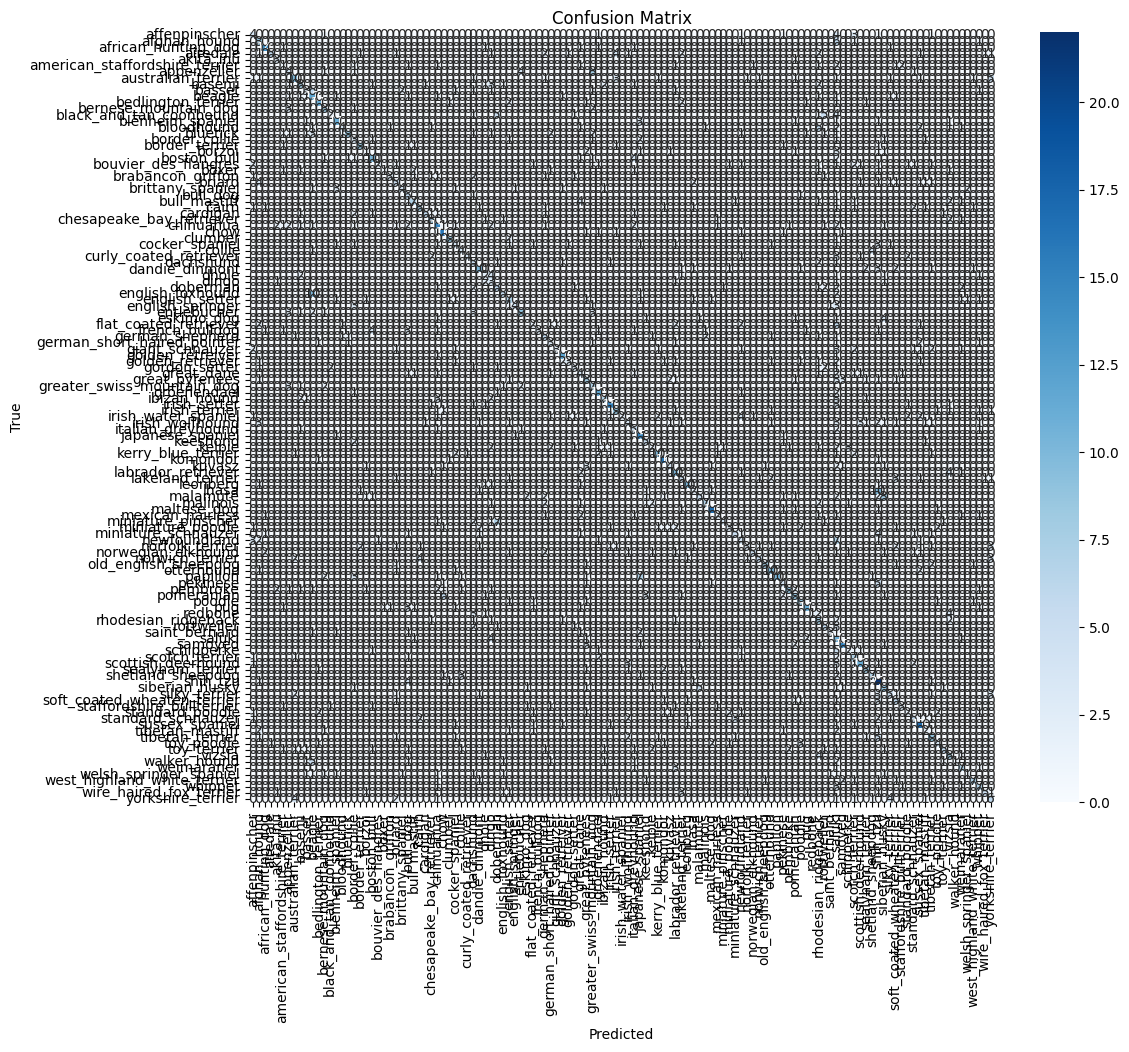

Evaluando modelo de clasificación...
Classification Report:
                                precision    recall  f1-score   support

                 affenpinscher       0.21      0.29      0.24        17
                  afghan_hound       0.32      0.59      0.42        17
           african_hunting_dog       0.68      0.75      0.71        20
                      airedale       0.88      0.28      0.42        25
                     akita_inu       0.38      0.75      0.50         4
american_staffordshire_terrier       0.12      0.08      0.10        13
                   appenzeller       0.19      0.21      0.20        19
            australian_terrier       0.50      0.40      0.44        30
                       basenji       0.43      0.48      0.45        21
                        basset       0.29      0.24      0.26        17
                        beagle       0.31      0.61      0.41        23
            bedlington_terrier       0.62      0.50      0.56        20
   

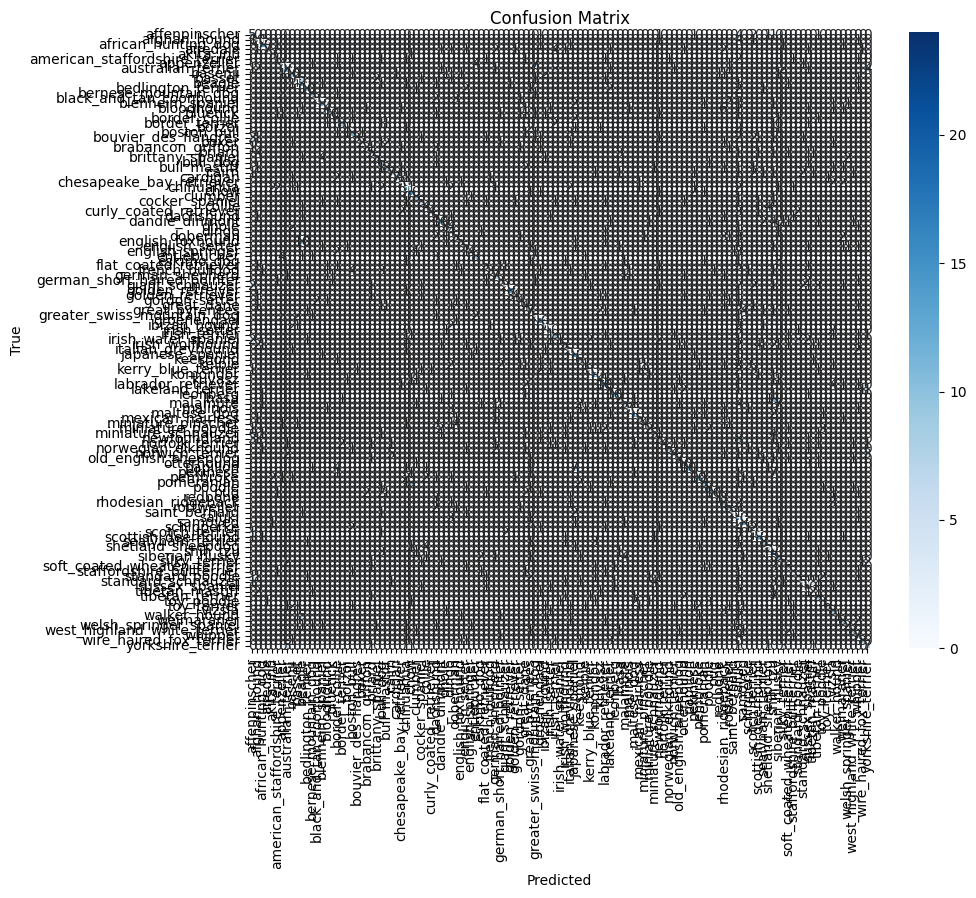

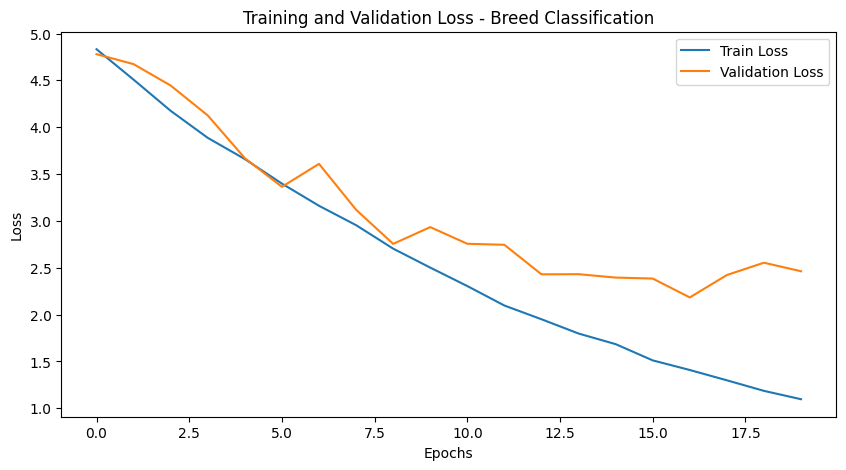

Modelo RAZAS guardado exitosamente en: models\resnet50_breed.pth
Dividiendo el dataset...
Train: 11144 | Val: 3184 | Test: 1593
Creando EmotionDataset...
EmotionDataset con 11144 muestras y 4 clases de emoción.
Creando EmotionDataset...
EmotionDataset con 3184 muestras y 4 clases de emoción.
Creando EmotionDataset...
EmotionDataset con 1593 muestras y 4 clases de emoción.
Creando EmotionClassifierResNet...
Entrenando modelo de clasificación...
Época 1/20 - Clasificación
Fin Época 1. Train Loss: 1.3404
Val Loss: 1.2943
Época 2/20 - Clasificación
Fin Época 2. Train Loss: 1.2624
Val Loss: 1.2266
Época 3/20 - Clasificación
Fin Época 3. Train Loss: 1.2356
Val Loss: 1.2507
Época 4/20 - Clasificación
Fin Época 4. Train Loss: 1.2159
Val Loss: 1.1995
Época 5/20 - Clasificación
Fin Época 5. Train Loss: 1.1973
Val Loss: 1.2239
Época 6/20 - Clasificación
Fin Época 6. Train Loss: 1.1917
Val Loss: 1.2132
Época 7/20 - Clasificación
Fin Época 7. Train Loss: 1.1781
Val Loss: 1.1883
Época 8/20 - Clasifi

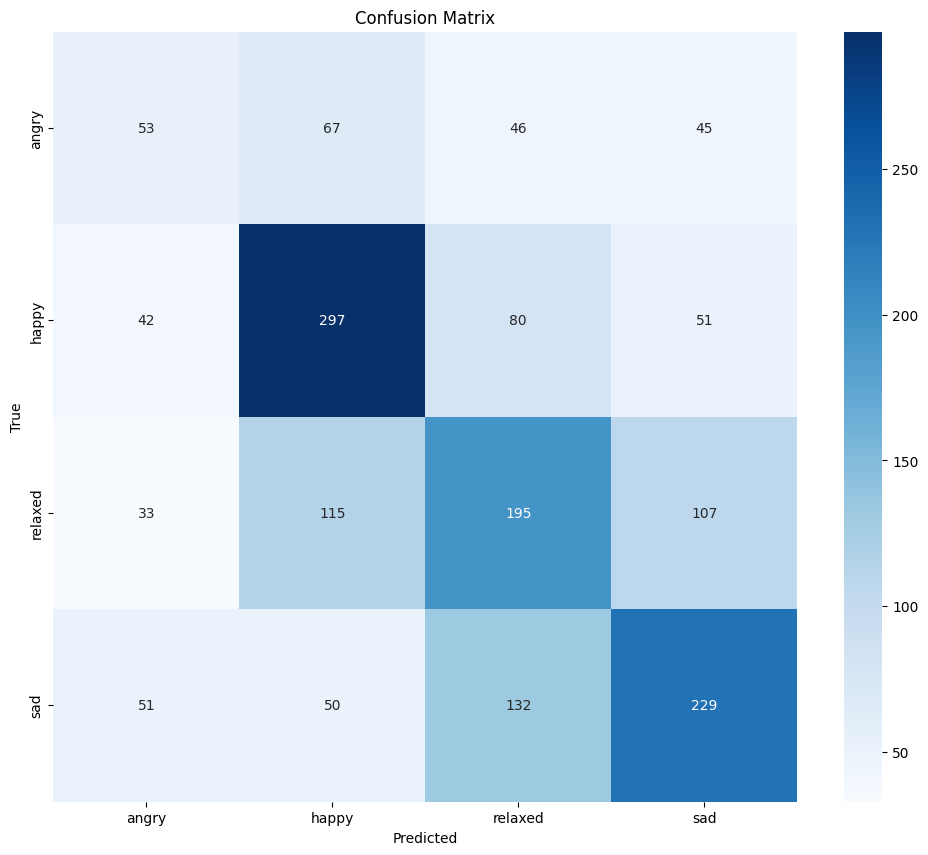

Evaluando modelo de clasificación...
Classification Report:
              precision    recall  f1-score   support

       angry       0.28      0.22      0.25       211
       happy       0.58      0.64      0.61       470
     relaxed       0.43      0.43      0.43       450
         sad       0.53      0.51      0.52       462

    accuracy                           0.49      1593
   macro avg       0.45      0.45      0.45      1593
weighted avg       0.48      0.49      0.48      1593



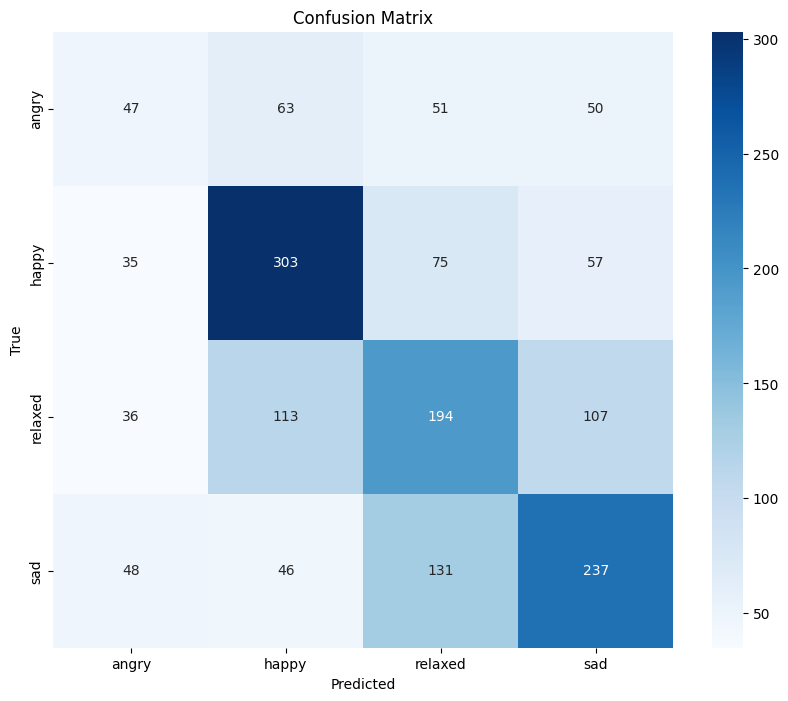

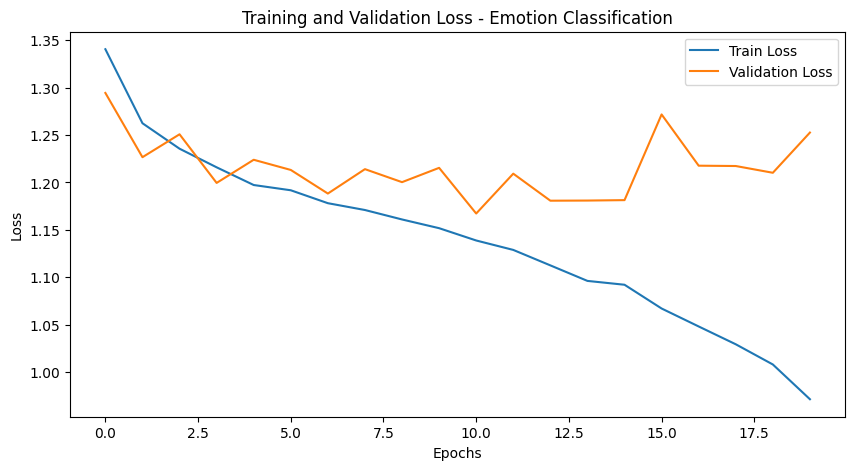

Modelo EMOCIONES guardado exitosamente en: models\resnet50_emotion.pth
Proceso finalizado. Modelos entrenados, evaluados y guardados (cuando procede).


In [25]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights

# Semilla para reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# ---------------------------------------------------------------------------
#                          CLASES DE DATASET
# ---------------------------------------------------------------------------
class StanfordDogsDataset(Dataset):
    """
    Carga el dataset de Stanford Dogs revisando únicamente la existencia de
    archivo de anotación .xml (sin parsearlo) para filtrar imágenes válidas.
    """
    def __init__(self, images_dir, annotations_dir, transform=None):
        print("Inicializando StanfordDogsDataset...")
        self.images_dir = os.path.normpath(images_dir)  # Normaliza las rutas
        self.annotations_dir = os.path.normpath(annotations_dir)
        self.transform = transform
        self.image_paths = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_paths.extend(glob.glob(os.path.join(self.images_dir, '*', ext)))
        self.labels = []
        self._prepare_dataset()


    def _prepare_dataset(self):
        print("Preparando Stanford Dogs dataset...")
        self.data = []
        for img_path in self.image_paths:
            # Normaliza la ruta
            img_path = os.path.normpath(img_path)
            breed = os.path.basename(os.path.dirname(img_path))  # Nombre de carpeta (puede contener prefijos)
            image_name = os.path.splitext(os.path.basename(img_path))[0]  # Nombre base sin extensión

            # Verifica si el nombre contiene prefijo (ej. n02085620)
            if '-' in breed:
                clean_breed = '-'.join(breed.split('-')[1:])  # Elimina prefijo numérico si existe
            else:
                clean_breed = breed  # No tiene prefijo

            # Ruta del archivo de anotación
            annotation_file = os.path.join(self.annotations_dir, breed, f"{image_name}.xml")
            annotation_file = os.path.normpath(annotation_file)  # Normaliza

            # Verifica si la anotación existe
            if not os.path.exists(annotation_file):
                print(f"Anotación faltante para la imagen: {img_path}")
                continue

            # Añade imagen válida
            self.data.append((img_path, clean_breed))
            self.labels.append(clean_breed)
        print(f"StanfordDogsDataset preparado con {len(self.data)} muestras.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


class BreedDataset(Dataset):
    """
    Dataset para clasificación de razas.
    """
    def __init__(self, dataframe, transform=None):
        print("Creando BreedDataset...")
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.breed_set = sorted(set(self.dataframe['Breed'].dropna()))
        self.breed_to_idx = {breed: idx for idx, breed in enumerate(self.breed_set)}
        self.idx_to_breed = {idx: breed for breed, idx in self.breed_to_idx.items()}
        print(f"BreedDataset con {len(self.dataframe)} muestras. {len(self.breed_set)} clases de raza.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
            row = self.dataframe.iloc[idx]
            image_path = row['image']
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            breed_label = self.breed_to_idx.get(row['Breed'], -1)
            
            if breed_label == -1:
                raise ValueError(f"Raza desconocida: {row['Breed']} en el índice {idx}")
            
            return image, breed_label
    

class EmotionDataset(Dataset):
    """
    Dataset para clasificación de emociones (etiqueta única).
    """
    def __init__(self, dataframe, transform=None):
        print("Creando EmotionDataset...")
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        # Solo filas con 'Emotion' no nulo
        self.dataframe = self.dataframe[self.dataframe['Emotion'].notna()].reset_index(drop=True)
        self.emotion_set = sorted(set(self.dataframe['Emotion'].dropna()))
        self.emotion_to_idx = {emotion: idx for idx, emotion in enumerate(self.emotion_set)}
        self.idx_to_emotion = {idx: emotion for emotion, idx in self.emotion_to_idx.items()}
        print(f"EmotionDataset con {len(self.dataframe)} muestras y {len(self.emotion_set)} clases de emoción.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        emotion_label = self.emotion_to_idx.get(row['Emotion'], -1)
        return image, emotion_label

# ---------------------------------------------------------------------------
#                          FUNCIONES AUXILIARES
# ---------------------------------------------------------------------------

def load_nine_breeds_dog_breeds(nine_breeds_path, transform=None):
    print("Cargando dataset de 9Breeds...")
    dataset = datasets.ImageFolder(root=nine_breeds_path, transform=transform)
    print(f"9Breeds cargado con {len(dataset.samples)} imágenes.")
    return dataset



def get_transforms():
    print("Creando transformaciones de imagen...")
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


def split_dataset(df, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=SEED):
    print("Dividiendo el dataset...")
    train_df, temp_df = train_test_split(df, train_size=train_ratio, random_state=seed)
    val_size = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(temp_df, train_size=val_size, random_state=seed)
    print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

# ---------------------------------------------------------------------------
#                          MODELOS
# ---------------------------------------------------------------------------
class BreedClassifierResNet(nn.Module):
    def __init__(self, num_breeds):
        super(BreedClassifierResNet, self).__init__()
        print("Creando BreedClassifierResNet...")
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_breeds)

    def forward(self, x):
        return self.resnet(x)


class EmotionClassifierResNet(nn.Module):
    def __init__(self, num_emotions):
        super(EmotionClassifierResNet, self).__init__()
        print("Creando EmotionClassifierResNet...")
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_emotions)

    def forward(self, x):
        return self.resnet(x)

# ---------------------------------------------------------------------------
#               FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# ---------------------------------------------------------------------------
def train_classification_model(model, train_loader, val_loader, class_names, device='cuda', epochs=10):
    """
    Entrena un modelo de clasificación (razas o emociones) con CrossEntropyLoss.
    """
    print("Entrenando modelo de clasificación...")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        print(f"Época {epoch+1}/{epochs} - Clasificación")
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Fin Época {epoch+1}. Train Loss: {avg_train_loss:.4f}")

        # Validación
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Val Loss: {avg_val_loss:.4f}")
    return train_losses, val_losses

def evaluate_classification_model(model, test_loader, class_names, device='cuda'):
    """
    Evalúa un modelo de clasificación mostrando el reporte de clasificación y la matriz de confusión.
    """
    print("Evaluando modelo de clasificación...")
    model.to(device)
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(predicted)
            true_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(true_labels, preds, target_names=class_names, zero_division=0))

    cm = confusion_matrix(true_labels, preds, labels=range(len(class_names)))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    """
    Evalúa un modelo de clasificación mostrando el reporte de clasificación y la matriz de confusión.
    """
    print("Evaluando modelo de clasificación...")
    model.to(device)
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(predicted)
            true_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(true_labels, preds, target_names=class_names))

    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_losses(train_losses, val_losses, title):
    """
    Grafica las curvas de pérdida de entrenamiento y validación.
    """
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

# ---------------------------------------------------------------------------
#                                MAIN
# ---------------------------------------------------------------------------
def main():
    print("Iniciando proceso para entrenar modelos separados para cada tarea...")

    # Directorios y rutas de interés
    stanford_images_path = './datasets/stanford_breeds/Images'
    stanford_annotations_path = './datasets/stanford_breeds/Annotation'
    nine_breeds_path = './datasets/9Breeds'
    emotion_path = './datasets/dogs_emotions'

    # Transformaciones de imagen
    transform = get_transforms()

    # Crear carpeta para guardar modelos
    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)

    # Cargar Stanford Dogs (sin transform)
    stanford_dataset = StanfordDogsDataset(stanford_images_path, stanford_annotations_path, transform=None)

    # Cargar dataset de 9Breeds (sin transform)
    nine_breeds_dataset = load_nine_breeds_dog_breeds(nine_breeds_path, transform=None)

    # Cargar dataset de emociones
    emotion_dataset = datasets.ImageFolder(root=emotion_path)

    # Combinar Stanford Dogs con 9Breeds
    breed_images = [img_path for img_path, _ in stanford_dataset.data] \
               + [path for path, _ in nine_breeds_dataset.samples]

    breed_labels = stanford_dataset.labels \
               + [nine_breeds_dataset.classes[label] for _, label in nine_breeds_dataset.samples]



    breed_labels_clean = [b.lower().replace('-', '_').replace(' ', '_') for b in breed_labels]

    df_breed = pd.DataFrame({'image': breed_images, 'Breed': breed_labels_clean})
    print(f"df_breed con {len(df_breed)} muestras.")

    print("Razas únicas en df_breed:")
    print(df_breed['Breed'].unique())
    
    # DataFrame para emociones
    emotion_images = [os.path.normpath(path) for path, _ in emotion_dataset.samples]
    emotion_labels_raw = [emotion_dataset.classes[label] for _, label in emotion_dataset.samples]
    emotion_labels_clean = []
    for e in emotion_labels_raw:
        # Ejemplo: Normalizar nombres de emoción (si se requiere)
        e_clean = e.lower().replace(' ', '_')
        emotion_labels_clean.append(e_clean)

    df_emotion = pd.DataFrame({'image': emotion_images, 'Emotion': emotion_labels_clean})
    print(f"df_emotion con {len(df_emotion)} muestras.")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # -----------------------------------------------------------------------
    # 1) MODELO RAZAS
    # -----------------------------------------------------------------------
    train_df_breed, val_df_breed, test_df_breed = split_dataset(
        df_breed,
        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,
        seed=SEED
    )
    train_dataset_breed = BreedDataset(train_df_breed, transform=transform)
    val_dataset_breed = BreedDataset(val_df_breed, transform=transform)
    test_dataset_breed = BreedDataset(test_df_breed, transform=transform)

    train_loader_breed = DataLoader(train_dataset_breed, batch_size=32, shuffle=True, num_workers=0)
    val_loader_breed = DataLoader(val_dataset_breed, batch_size=32, shuffle=False, num_workers=0)
    test_loader_breed = DataLoader(test_dataset_breed, batch_size=32, shuffle=False, num_workers=0)

    model_breed = BreedClassifierResNet(num_breeds=len(train_dataset_breed.breed_set))

    breed_train_losses, breed_val_losses = train_classification_model(
        model_breed, train_loader_breed, val_loader_breed,
        class_names=train_dataset_breed.breed_set, device=device, epochs=20  
    )

    evaluate_classification_model(
        model_breed, test_loader_breed,
        class_names=train_dataset_breed.breed_set, device=device
    )

    plot_losses(breed_train_losses, breed_val_losses,
                'Training and Validation Loss - Breed Classification'
                )
    
    try:
        model_breed_path = os.path.join(model_dir, "resnet50_breed.pth")
        torch.save(model_breed.state_dict(), model_breed_path)
        print(f"Modelo RAZAS guardado exitosamente en: {model_breed_path}")
    except Exception as e:
        print(f"Error al guardar el modelo RAZAS: {e}")

    # -----------------------------------------------------------------------
    # 2) MODELO EMOCIONES
    # -----------------------------------------------------------------------

    if len(df_emotion) < 1:
        print("No hay datos de emociones disponibles para entrenar el modelo de emociones.")
    else:
        train_df_emo, val_df_emo, test_df_emo = split_dataset(
            df_emotion,
            train_ratio=0.7,
            val_ratio=0.2,
            test_ratio=0.1,
            seed=SEED
        )
        train_dataset_emo = EmotionDataset(train_df_emo, transform=transform)
        val_dataset_emo = EmotionDataset(val_df_emo, transform=transform)
        test_dataset_emo = EmotionDataset(test_df_emo, transform=transform)

        train_loader_emo = DataLoader(train_dataset_emo, batch_size=32, shuffle=True, num_workers=0)
        val_loader_emo = DataLoader(val_dataset_emo, batch_size=32, shuffle=False, num_workers=0)
        test_loader_emo = DataLoader(test_dataset_emo, batch_size=32, shuffle=False, num_workers=0)

        model_emo = EmotionClassifierResNet(num_emotions=len(train_dataset_emo.emotion_set))

        emo_train_losses, emo_val_losses = train_classification_model(
            model_emo, train_loader_emo, val_loader_emo,
            class_names=train_dataset_emo.emotion_set, device=device, epochs=20
        )

        evaluate_classification_model(
            model_emo, test_loader_emo,
            class_names=train_dataset_emo.emotion_set, device=device
        )

        plot_losses(emo_train_losses, emo_val_losses,
                    'Training and Validation Loss - Emotion Classification')

        try:
            emotion_model_path = os.path.join(model_dir, "resnet50_emotion.pth")
            torch.save(model_emo.state_dict(), emotion_model_path)
            print(f"Modelo EMOCIONES guardado exitosamente en: {emotion_model_path}")
        except Exception as e:
            print(f"Error al guardar el modelo EMOCIONES: {e}")


    print("Proceso finalizado. Modelos entrenados, evaluados y guardados (cuando procede).")

# ---------------------------------------------------------------------------
#                        EJECUCIÓN PRINCIPAL
# ---------------------------------------------------------------------------
if __name__ == '__main__':
    main()


In [27]:
import os
import glob
from xml.etree import ElementTree as ET


annotations_dir = './datasets/stanford_breeds/Annotation'

# Iterar por cada subcarpeta de anotaciones
for root, dirs, files in os.walk(annotations_dir):
    for file in files:
        # Verificar si el archivo NO tiene extensión .xml
        if not file.endswith('.xml'):
            old_path = os.path.join(root, file)
            new_path = os.path.join(root, file + '.xml')  # Añadir la extensión

            # Renombrar archivo
            os.rename(old_path, new_path)
            print(f'Renombrado: {old_path} -> {new_path}')

print("Proceso de renombrado completado.")


def test_annotations(images_dir, annotations_dir):
    print("Verificando correspondencia entre imágenes y anotaciones...")
    errors = []
    total_images = 0
    total_annotations = 0

    # Normalizar rutas base
    images_dir = os.path.normpath(images_dir)
    annotations_dir = os.path.normpath(annotations_dir)

    print(f"Directorio de imágenes: {images_dir}")
    print(f"Directorio de anotaciones: {annotations_dir}")

    # Iterar sobre carpetas de razas
    for breed_folder in os.listdir(images_dir):
        image_folder = os.path.normpath(os.path.join(images_dir, breed_folder))
        annotation_folder = os.path.normpath(os.path.join(annotations_dir, breed_folder))

        print(f"\nProcesando imágenes: {image_folder}")
        print(f"Esperando anotaciones en: {annotation_folder}")

        # Verificar existencia de carpetas
        if not os.path.isdir(image_folder):
            print(f"No encontrado: {image_folder}")
            continue
        if not os.path.isdir(annotation_folder):
            print(f"No encontrado: {annotation_folder}")
            continue

        # Buscar archivos
        image_files = glob.glob(os.path.join(image_folder, '*.jpg'))
        annotation_files = glob.glob(os.path.join(annotation_folder, '*.xml'))

        print(f"Imágenes encontradas: {len(image_files)}")
        print(f"Anotaciones encontradas: {len(annotation_files)}")

        # Actualizar contadores
        total_images += len(image_files)
        total_annotations += len(annotation_files)

        # Crear mapa de anotaciones
        annotation_map = {os.path.splitext(os.path.basename(x))[0]: os.path.normpath(x) for x in annotation_files}

        # Comparar imágenes con anotaciones
        for image_path in image_files:
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            expected_annotation = os.path.normpath(os.path.join(annotation_folder, f"{image_name}.xml"))
            image_path_norm = os.path.normpath(image_path)

            # Validar existencia del archivo
            if not os.path.exists(expected_annotation):
                # BUSCAR ARCHIVO SIN EXTENSIÓN
                possible_matches = glob.glob(os.path.join(annotation_folder, image_name + '*'))
                if possible_matches:
                    errors.append(f"Formato no válido para {image_path_norm}, encontrado: {possible_matches[0]}")
                else:
                    errors.append(f"Anotación faltante para: {image_path_norm}")
                continue

            # Verificar formato XML
            try:
                tree = ET.parse(expected_annotation)
                root = tree.getroot()
                breed_name = root.find(".//name").text
                if not breed_name:
                    errors.append(f"Etiqueta vacía en: {expected_annotation}")
            except Exception as e:
                errors.append(f"Error al leer {expected_annotation}: {str(e)}")

    # Resumen
    print("\n--- Resultados del Test ---")
    print(f"Total imágenes encontradas: {total_images}")
    print(f"Total anotaciones encontradas: {total_annotations}")
    print(f"Errores detectados: {len(errors)}")

    if errors:
        print("\nErrores encontrados:")
        for error in errors[:20]:
            print(error)
        if len(errors) > 20:
            print(f"... y {len(errors) - 20} más errores.")
    else:
        print("¡Todas las anotaciones están en orden!")

# Ejecutar el test
test_annotations(
    images_dir='./datasets/stanford_breeds/Images',
    annotations_dir='./datasets/stanford_breeds/Annotation'
)


Proceso de renombrado completado.
Verificando correspondencia entre imágenes y anotaciones...
Directorio de imágenes: datasets\stanford_breeds\Images
Directorio de anotaciones: datasets\stanford_breeds\Annotation

Procesando imágenes: datasets\stanford_breeds\Images\n02085620-Chihuahua
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085620-Chihuahua
Imágenes encontradas: 152
Anotaciones encontradas: 152

Procesando imágenes: datasets\stanford_breeds\Images\n02085782-Japanese_spaniel
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085782-Japanese_spaniel
Imágenes encontradas: 185
Anotaciones encontradas: 185

Procesando imágenes: datasets\stanford_breeds\Images\n02085936-Maltese_dog
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085936-Maltese_dog
Imágenes encontradas: 252
Anotaciones encontradas: 252

Procesando imágenes: datasets\stanford_breeds\Images\n02086079-Pekinese
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n

KeyboardInterrupt: 

In [33]:
import os
import torch
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from PIL import Image
import torch.nn as nn


class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


# Función de predicción
def predict_image(
        image_path,
        model_path,
        classes,
        threshold=0.50,
        device='cuda' if torch.cuda.is_available() else 'cpu'
):
    # Preprocesamiento de imagen
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Cargar imagen
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Cargar modelo
    model = ResNetClassifier(len(classes))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Predicción
    with torch.no_grad():
        output = torch.softmax(model(image), dim=1)
        confidence, idx = torch.max(output, dim=1)
        confidence = confidence.item()
        prediction = classes[idx.item()] if confidence >= threshold else "Unknown"

    return {'class': prediction, 'confidence': f"{confidence * 100:.2f}%"}


# Rutas a los modelos
BREED_MODEL_PATH = 'models/resnet50_breed.pth'
EMOTION_MODEL_PATH = 'models/resnet50_emotion.pth'

# Clases
breed_classes = [
    'chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih_tzu',
    'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback',
    'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick',
    'black_and_tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone',
    'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound',
    'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound',
    'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier',
    'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier',
    'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier',
    'wire_haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier',
    'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull',
    'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer',
    'scotch_terrier', 'tibetan_terrier', 'silky_terrier',
    'soft_coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa',
    'flat_coated_retriever', 'curly_coated_retriever', 'golden_retriever',
    'labrador_retriever', 'chesapeake_bay_retriever',
    'german_short_haired_pointer', 'vizsla', 'english_setter', 'irish_setter',
    'gordon_setter', 'brittany_spaniel', 'clumber', 'english_springer',
    'welsh_springer_spaniel', 'cocker_spaniel', 'sussex_spaniel',
    'irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois',
    'briard', 'kelpie', 'komondor', 'old_english_sheepdog', 'shetland_sheepdog',
    'collie', 'border_collie', 'bouvier_des_flandres', 'rottweiler',
    'german_shepherd', 'doberman', 'miniature_pinscher',
    'greater_swiss_mountain_dog', 'bernese_mountain_dog', 'appenzeller',
    'entlebucher', 'boxer', 'bull_mastiff', 'tibetan_mastiff', 'french_bulldog',
    'great_dane', 'saint_bernard', 'eskimo_dog', 'malamute', 'siberian_husky',
    'affenpinscher', 'basenji', 'pug', 'leonberg', 'newfoundland',
    'great_pyrenees', 'samoyed', 'pomeranian', 'chow', 'keeshond',
    'brabancon_griffon', 'pembroke', 'cardigan', 'toy_poodle', 'miniature_poodle',
    'standard_poodle', 'mexican_hairless', 'dingo', 'dhole',
    'african_hunting_dog', 'akita_inu', 'bull_dog', 'dachshund',
    'golden_retreiver', 'poodle'
]

emotion_classes = ['happy', 'sad', 'angry', 'relaxed']

# Imagen a predecir
image_path = 'labrador-retriever-happy.jpg'

# Predicción de raza
breed_prediction = predict_image(image_path, BREED_MODEL_PATH, breed_classes)
print("Breed Prediction:", breed_prediction)

# Predicción de emoción
emotion_prediction = predict_image(image_path, EMOTION_MODEL_PATH, emotion_classes)
print("Emotion Prediction:", emotion_prediction)


C:\Users\elena\AppData\Local\Temp\ipykernel_880\2579104803.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

Breed Prediction: {'class': 'west_highland_white_terrier', 'confidence': '84.20%'}
Emotion Prediction: {'class': 'sad', 'confidence': '86.56%'}
